In [18]:
'''
metrics-comparison.ipynb
Notebook creates the visual outcome for the comparison of metrics
'''

import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import seaborn as sns
import altair as alt

DIR_ROOT = os.path.join(pathlib.Path().absolute(), '../../..' )

In [2]:
# list of all metrices used in the analysis
metrics = [
    'act_sum',
    'day_sum',
    'stay_avg',
    'stay_sum',
    
    'travel',
 
    'centr_closes',
    'centr_between',
    'centr_eigen',
    'centr_infos',
    
    'infl_dist',
    'infl_reg',
    'infl_sum',
]

In [3]:
# merge all metrices with the list of destinations

df = pd.read_csv(DIR_ROOT + '/data/02_processed/destinations.csv', index_col='name')

for metric in metrics:
    df_metric = pd.read_csv(DIR_ROOT + '/data/05_metrics/' + metric + '.csv', index_col=0)
    df_metric.rename(columns={
       'p1': metric + '_p1', 
       'p2': metric + '_p2',
       'p3': metric + '_p3',
       'p4': metric + '_p4',
       'p5': metric + '_p5',
       'pall': metric + '',
    }, inplace=True)
    df_metric.drop(columns=['geometry'], inplace=True) 
    df_metric = (df_metric - df_metric.min()) / (df_metric.max() - df_metric.min())

    # merge to the table with all destinations
    df = pd.concat([df, df_metric], axis=1, join="inner")

In [4]:
df['median'] = df.apply(lambda x: x[metrics].median(), axis=1)
df['median_p1'] = df.apply(lambda x: x[[m + '_p1' for m in metrics]].median(), axis=1)
df['median_p2'] = df.apply(lambda x: x[[m + '_p2' for m in metrics]].median(), axis=1)
df['median_p3'] = df.apply(lambda x: x[[m + '_p3' for m in metrics]].median(), axis=1)
df['median_p4'] = df.apply(lambda x: x[[m + '_p4' for m in metrics]].median(), axis=1)
df['median_p5'] = df.apply(lambda x: x[[m + '_p5' for m in metrics]].median(), axis=1)
df.sort_values('median', ascending=False)

,Unnamed: 0,id,no_alle,no_activity,no_reise,no_bi,no_gg,x,y,prazision,...,infl_sum_p3,infl_sum_p4,infl_sum_p5,infl_sum,median,median_p1,median_p2,median_p3,median_p4,median_p5
Praha,419,421.0,401.0,172.0,176.0,44.0,9.0,50.090,14.410,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.105526,0.971662,1.000000,1.000000,1.000000
Wien,631,632.0,271.0,116.0,124.0,23.0,8.0,48.221,16.388,1.0,...,0.358025,0.893333,NaN,0.723005,0.689110,0.782799,0.863019,0.325564,0.635837,0.000000
Brno,45,44.0,103.0,42.0,47.0,10.0,4.0,49.190,16.610,1.0,...,0.123457,0.413333,0.411765,0.300469,0.421920,0.000000,0.313725,0.169520,0.497014,0.546875
Písek,395,396.0,28.0,13.0,13.0,1.0,1.0,49.309,14.148,1.0,...,0.148148,0.093333,NaN,0.117371,0.257857,0.000000,0.225850,0.309853,0.128969,0.000000
Krems an der Donau,228,229.0,73.0,30.0,30.0,6.0,7.0,48.410,15.620,1.0,...,NaN,0.026667,NaN,0.173709,0.252561,0.966667,0.529052,0.000000,0.114588,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hartberg,151,150.0,2.0,1.0,1.0,0.0,0.0,47.281,15.970,1.0,...,NaN,NaN,NaN,NaN,0.000125,0.000000,0.000000,0.000000,0.000721,0.000000
Völkermarkt,604,606.0,2.0,1.0,1.0,0.0,0.0,46.662,14.633,1.0,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Seitenstetten,495,498.0,5.0,1.0,1.0,3.0,0.0,48.036,14.655,1.0,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Čáslav,53,52.0,5.0,1.0,1.0,2.0,1.0,49.910,15.389,1.0,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
# get localities on positions < max_rank

max_rank = 10

df_matrices_order = pd.DataFrame(index=df.index)

for metric in metrics:
    df_copy = df.copy()
    df_copy.sort_values(metric, inplace=True, ascending=False)
    df_copy.reset_index(inplace=True)
    df_copy['rank'] = df_copy.index.values
    df_copy.set_index('index', inplace=True)
    df_matrices_order[metric] = df_copy[['rank']] + 1

# get list of important places
imp_places = []
for metric in metrics:
    imp_places_m = df_matrices_order[df_matrices_order[metric] <= max_rank].index
    imp_places.extend(imp_places_m)

imp_places = np.unique(np.array(imp_places))

imp_places = df_matrices_order.loc[imp_places]
imp_places['name'] = imp_places.index
imp_places['region'] = df['region0']
imp_places['median'] = df['median']
imp_places

,act_sum,day_sum,stay_avg,stay_sum,travel,centr_closes,centr_between,centr_eigen,centr_infos,infl_dist,infl_reg,infl_sum,name,region,median
Arnoldstein,55,67,67,52,8,83,62,84,83,72,71,72,Arnoldstein,Kärnten,0.001956
Brno,3,3,11,3,2,6,6,3,3,34,3,3,Brno,Mähren,0.421920
Budyně nad Ohří,21,10,5,20,23,30,29,18,22,62,37,33,Budyně nad Ohří,Böhmen,0.055782
Eggenburg,65,28,7,62,44,68,73,40,52,13,40,44,Eggenburg,Niederösterreich,0.031138
Graz,6,16,39,13,4,60,51,10,8,43,6,6,Graz,Steiermark,0.152045
Głubczyce,33,21,18,27,7,59,47,36,25,11,43,42,Głubczyce,Schlesien,0.038222
Herzogenbirbaum,70,65,61,67,72,4,63,44,42,3,63,63,Herzogenbirbaum,Niederösterreich,0.014936
Hradec Králové,22,7,3,21,13,50,37,24,21,48,25,19,Hradec Králové,Böhmen,0.068067
Hradec nad Moravicí,27,43,48,35,26,54,68,66,61,1,64,37,Hradec nad Moravicí,Schlesien,0.019428
Jihlava,18,17,47,9,33,18,80,7,10,26,14,18,Jihlava,Böhmen,0.100440


In [6]:
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']

imp_places['rcolor'] = imp_places.apply(
    lambda x: colors[imp_places['region'].unique().tolist().index(x['region'])],
    axis=1
)


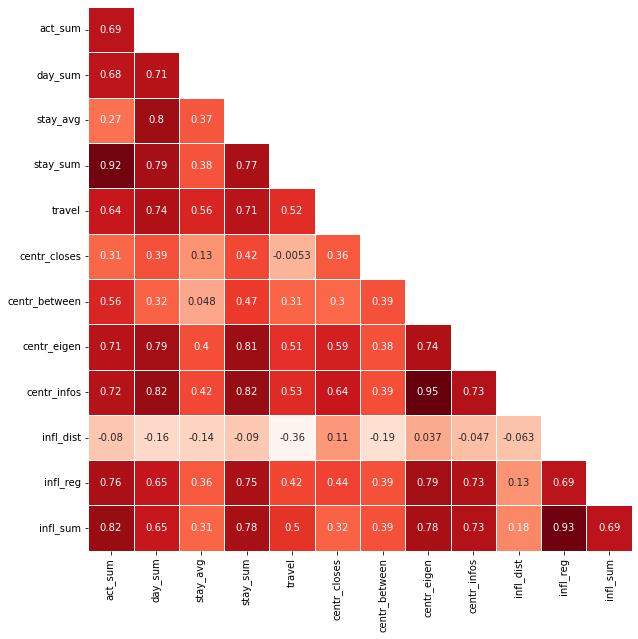

In [16]:
# draw correlation matrix

corr = imp_places[metrics].corr()
# corr.mean())

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# print(mask)

plt.figure(figsize=(15,10))
cscheme = cm.get_cmap('Reds', 256)
newcolors = cscheme(np.linspace(0, 1, 256))

for mi, metric in enumerate(corr.index):
    corr.at[metric, metric] = corr.median()[metric]
    mask[mi][mi] = False

black = np.array([0.4,0.4,0.4,1])
# white color at the beginning of the scale, black at the end
#newcolors[255:256, :] = black
newcmp = ListedColormap(newcolors)


sns.heatmap(corr, cmap=newcmp, annot=True, cbar=False, mask=mask, linewidth=1, linecolor='w', square=True)
plt.show()

In [8]:
corr.index = corr.index + str(corr.mean()[corr.index])

In [19]:
alt.renderers.set_embed_options(
    padding={"left": 5, "right": 10, "bottom": 5, "top": 0}
)

imp_places['lines'] = imp_places.apply(
    lambda x: len(x['name'].split(' ')) * 3,
    axis = 1
)
imp_places['csize'] = imp_places.apply(
    lambda x: x['median'] * 500,
    axis = 1
)

rank_chart = alt.Chart(imp_places).transform_window(
    index='count()'
).transform_fold(
    metrics
).properties(
    width=1200,
    height=600
).encode(
    
    #color=alt.Color('rcolor:', legend=None, scale=None),
    x=alt.X(
        'key:N',
        axis=alt.Axis(title='metrics'),
        sort=metrics
    ),
    y=alt.Y(
        'value:Q', 
        scale=alt.Scale(zero=False, domain=[max_rank + 0.2,0.1], nice=False),
        axis=alt.Axis(values=[i for i in range(1, max_rank+1)], tickMinStep=0.1, title='rank', format='.0f'),
    ),
)

lines = rank_chart.mark_line(
    clip=True,
    strokeWidth=.5,
    strokeDash=[5,3]
)

circles = rank_chart.mark_circle(
    clip=True,
    strokeOpacity=1,
    strokeWidth=1.5,
    stroke='grey'
).encode(
    size=alt.Size('csize:N', legend=None, scale=None),
    color=alt.Color('rcolor:Q', legend=None, scale=None),
    stroke=alt.Color('rcolor:N', legend=None, scale=None),
)

labels = rank_chart.mark_text(
    clip=True,
    align='center',
    baseline='bottom',
    lineHeight=11,
    fontSize=10,
    fontWeight='bold',
    fill='black',
    lineBreak=' ',
    color="black",
    dy=-20
).encode(
    y=alt.Y('value:Q'),
    text='name:N',
)

circles + labels

alt.LayerChart(...)

In [10]:
time_medians = ['median_p1', 'median_p2', 'median_p3', 'median_p4', 'median_p5']

time_df = df[time_medians + ['region0', 'median']]
time_df['name'] = time_df.index
time_df.rename(columns= {
    'median_p1': 'period 1',
    'median_p2': 'period 2', 
    'median_p3': 'period 3', 
    'median_p4': 'period 4', 
    'median_p5': 'period 5'
}, inplace=True)
time_medians = ['period 1', 'period 2', 'period 3', 'period 4', 'period 5']

locations_by_median = time_df.sort_values(['median'], inplace=True, ascending=False)

time_df = time_df[time_df['median'] > 0.05]
time_df['region'] = df['region0']
time_df['rcolor'] = imp_places['rcolor']

imp_pl_rs = imp_places['region'].unique().tolist()
time_df['rcolor'] = time_df.apply(
    lambda x: colors[imp_pl_rs.index(x['region'])] if x['region'] in imp_pl_rs else colors[len(colors) - 1],
    axis=1
)


time_chart = alt.Chart(time_df).transform_window(
    index='count()'
).transform_fold(
    time_medians
).properties(
    width=1000,
    height=200
).encode(
    color=alt.Color('rcolor', legend=None),
    x=alt.X(
        'name:N',
        axis=alt.Axis(title='localities'),
        sort=locations_by_median
    ),
    y=alt.Y(
        'key:N',
        scale=alt.Scale(zero=False, domain=time_medians, nice=False),
    ),
)

circles = time_chart.mark_circle(
    clip=True,
    strokeOpacity=1,
    strokeWidth=1.5,
    fillOpacity=1,
    stroke='grey'
).encode(
    size=alt.Size('value:Q', legend=None),
    color=alt.Color('rcolor:N', legend=None, scale=None),
)

circles

/tmp/ipykernel_20994/3715898238.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df['name'] = time_df.index
/home/adam/.local/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/adam/.local/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

alt.Chart(...)

In [11]:
df.to_csv(DIR_ROOT + '/data/06_outputs/localities.csv')